In [3]:
from manager import load_obj
import os
import re
import string
from collections import Counter
from pprint import pprint
from tqdm.notebook import tqdm
from itertools import combinations

In [4]:
works = load_obj("germanistik")

In [5]:
count= 0
for work in works:
    if work.references != "none":
        count += 1

In [6]:
count

603

In [7]:
index_work = {}
for index,work in enumerate(works):
    index_work[work.link.split("/")[-1]] = index

In [8]:


def find_tag(text, tag):
    """return the text of a given label"""
    reg_start = re.compile(fr"(\<{tag}\>)")
    reg_end =  re.compile(fr"(\<\/{tag}\>)")
    start = [m.start() for m in re.finditer(reg_start, text)]
    end = [m.start() for m in re.finditer(reg_end, text)]
    
    aut=""
    if start and end:
        for s,e in zip(start,end):
            aut += re.sub(r"<[^>]*>", "", text[s:e] + "  ")
    else:
        aut = ""
    return aut

In [9]:
def create_ref_dic(text):
    """-creates a dictionary with all authors from a bibliography
       -gets as input the parsed authors from EXparser 
    """
    references ={"autoren": []}
    refs = text.split("<\/sequence")
    for ref in refs:
        text = find_tag(ref, "author")
        authors = re.split("  |\/", text)
        
        authors = [x for x in authors if len(x) > 0]
        if len(authors) != 0:
            references["autoren"] += authors
    return references

In [10]:
path = r"C:\Users\Tim\Desktop\bachelorarbeit\Parsed_References"
for filename in os.listdir(r"C:\Users\Tim\Desktop\bachelorarbeit\Parsed_References"):
    with open(os.path.join(path, filename), 'r', encoding = "utf-8") as f: # open in readonly mode
        name = os.path.basename(f.name).split(".")[0]
        if index_work.get(name) != None:
            works[index_work.get(name)].ref_authors = create_ref_dic(f.read())

# Get Most Common Autors (only once per Document)

### Heuristic detection of same label (next two fields)

In [11]:
def compare_names(author, dic):
    """-creates a dictionary from all occurences of an author 
    """
    new_dic = dic
    namelist = list(new_dic.keys())
    count = 0
    appended = False
    if len(namelist) != 0:
        
        for nam in namelist:
            if is_author(author, nam):
                count = 0
                for entry in new_dic[nam]:
                    if is_author(author, entry):
                        count += 1
                
                if count/len(new_dic[nam]) >= 0.7:
                    new_dic[nam] += [author]
                    return new_dic
                else:
                    new_dic[nam] = [author]
                    return new_dic
            else:
                continue
        new_dic[author]=[author]
        return new_dic
                
    else:
        new_dic[author] = [author]
        return new_dic

In [12]:
def is_author(author, compare):
    """
       -checks if two author names are the same (e.g. Friedrich W. Nietzsche, F. Nietzsche)
       -heuristic approach
    """
    name = author.split(" ")
    name = list(filter(None, name))
    name_compare = compare.split(" ")
    name_compare = list(filter(None, name_compare))
    flag = False
    full_name_flag = False
    if len(name) >= len(name_compare):
        prob = len(name_compare)
        tmp = name_compare
        name_compare = name
        name = tmp
    else:
        prob = len(name)
    new_prob = 0   

    beginners_n = [x[0] for x in name] #first characters of names
    beginners_nc = [x[0] for x in name_compare]
    
    
    
    for n in beginners_n:
        if n in beginners_nc:
            beginners_nc.remove(n)
        else:
            return False
            
    for i, n in enumerate(name):
            
            for j,nc in enumerate(name_compare):
                if (i==j) and (nc == n):
                    new_prob +=1
            
            if new_prob/prob > 0.5:
                return True
            
            elif n[0] not in (x[0] for x in name_compare):
                flag = False
                break

                
            elif (len(n) > 1) and n in name_compare:
                flag = True
                full_name_flag = True
    
            else:
              
                for nc in name_compare:
                    if (n[0] == nc[0]) and ((len(nc) == 1) or (len(n) == 1)):
                        flag = True    
                        
                    elif(n[0] == nc[0]):
                        control = min(len(n), len(nc))
                        if n[:control]!= nc[:control]:
                            return False
                    
                    
    if flag and full_name_flag:
        return True
    else:
        return False

In [13]:
count = 0
authors = []

"""
    -this field extracts the authors of the parsed references from a bibliohgraphy
    -sounts multiple mentions of a name in the same bibliography only once
"""

for work in tqdm(works):
    if work.references != "none" and work.link.split("/")[-1] != "283936":
       

        dics = {}
        
       
        auts = [x.lower() for x in work.ref_authors["autoren"]]
       
        auts = [x.translate(str.maketrans('', '', string.punctuation)) for x in auts]
        
        for aut in auts:
            # if author longer than 5 skip name
            if len(aut.split(" ")) >= 5 or aut == "" or len(aut.split(" ")) == 1:
                continue
            dics = compare_names(aut, dics)
            count += 1
        
        authors += list(dics.keys())

final_dic = {}
for aut in tqdm(authors):
    final_dic = compare_names(aut, final_dic) 
    


  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/6920 [00:00<?, ?it/s]

In [14]:
result = dict(sorted(final_dic.items(), key=lambda item: len(item[1]), reverse = True))

In [15]:
final_result = {}
for key, value in result.items():
    final_result[key] = len(value)

In [16]:
len(final_result.keys())

5217

# Create Node- and Edgelist for Co-authorship



In [202]:
#filter out authors that occur only once in the whole corpus
list_authors = [k for k,v in final_result.items() if v >= 2]

In [203]:
len(list_authors)

823

In [204]:
"""create a dictionary (cowriters) of authors who appear together in the same bibliography"""
cowriters = {}
for elem in list_authors:
    cowriters[elem] = []
    
count = 0

for work in tqdm(works):
    if work.references != "none" and work.link.split("/")[-1] != "283936":
        dic ={}

        ## if author longer than 6 skip name!!  
        auts = [x.lower() for x in work.ref_authors["autoren"]]
        auts = [x.translate(str.maketrans('', '', string.punctuation)) for x in auts]
        
        for aut in auts:
            if len(aut.split(" ")) >= 5 or aut == "" or len(aut.split(" ")) == 1:
                continue
            else:
                dic = compare_names(aut, dic)
        
        authors = list(dic.keys()) 
        for index, a in enumerate(authors):
            for na in list_authors:
                if is_author(a,na):
                    authors[index] = na
                    break
    
    
        for aut in authors:
            for n in list_authors:
                if is_author(aut,n):
                    cowriters[n] += authors
                    break


  0%|          | 0/1028 [00:00<?, ?it/s]

In [205]:
new_co ={}
for key, val in cowriters.items():
    res = {}
    for name in val:
        if len(name.split(" ")) >= 5 or aut == "" or len(name.split(" ")) == 1:
                continue
        new_co[key] = compare_names(name , res)

In [206]:
for key, val in new_co.items():
    new_co[key] = dict(sorted(val.items(), key=lambda item: len(item[1]), reverse = True))
    for k,v in val.items():
        new_co[key][k] = len(v)


    

In [207]:
len(new_co.keys())

823

In [208]:
for key, val in list(new_co.items()):
    for k,v in list(val.items()):
        if v < 2:
            del new_co[key][k]

In [209]:
for key, val in list(new_co.items()):
    for k,v in list(val.items()):
        if is_author(k,key):
            del new_co[key][k]

In [210]:
for key, val in list(new_co.items()):
    if not val:
        del new_co[key]

In [211]:
"""rename some authors, because of failed parsings"""
for index, val in enumerate(new_keys):
    if val == "friedrich nietzsche der":
        new_keys[index] = "friedrich nietzsche"
    if val == "arendt hannah franz":
        new_keys[index] = "arendt hannah"
    if val == "fleischer wolfgang barz irmhild":
        new_keys[index] = "fleischer wolfgang"
    if val == "mann thomas „der":
        new_keys[index] = "mann thomas"
    if val == "hatmann von":
        new_keys[index] = "hartmann von aue"
    
    

In [212]:
key_list = []
id_dic ={}
for key, value in new_co.items():
    key_list += value.keys()
    key_list += new_co.keys()
    key_list = list(set(key_list))


count = 0
for name in key_list:
    id_dic[name] = count
    count+=1


In [213]:
print(len(id_dic))

385


In [214]:
new_co

{'goethe johann wolfgang': {'schmidt jochen': 4,
  'wilpert gero': 4,
  'nietzsche friedrich': 3,
  'eckermann johann peter': 3,
  'müller joachim': 3,
  'meier albert': 2,
  'spillner bernd': 2,
  'rousseau jeanjacques': 2,
  'neumann gerhard': 2,
  'mann thomas „der': 2,
  'freund winfried': 2,
  'lenz jacob michael': 2,
  'lessing gotthold e': 2,
  'blessin stefan johann wolfgang': 2,
  'karthaus ulrich sturm': 2,
  'vaget hans rudolf': 2,
  'martini fritz': 2,
  'michelsen peter goethes': 2,
  'hamm heinz': 2,
  'von goethe johann': 2},
 'bumke joachim': {'hartmann von': 6,
  'wolfram von eschenbach': 6,
  'wehrli max': 5,
  'haug walter': 4,
  'mohr wolfgang': 4,
  'wapnewski peter': 4,
  'maurer f': 4,
  'cormeau christoph': 3,
  'brunner horst': 3,
  'fisher rodney': 3,
  'heinzle joachim': 3,
  'kuhn hugo': 3,
  'schröder werner': 3,
  'schwietering julius': 3,
  'weber gottfried': 3,
  'ruh kurt': 3,
  'weddige hilkert': 3,
  'althoff gerd': 3,
  'kartschoke dieter': 3,
  'rei

In [215]:
#### create node csv
import csv

with open("gephi/node_germanistik_all.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Id", "Label"])
    for key, value in id_dic.items():
        writer.writerow([value, key])

In [216]:
### create edge csv
import csv

with open("gephi/edge_germanisitk_all.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Source", "Target", "Weight"])
    for key, value in new_co.items():
        for k,v in value.items():
         
            writer.writerow([id_dic.get(key), id_dic.get(k), v])

# Some statistics



['goethe johann wolfgang', 'bumke joachim', 'nietzsche friedrich', 'hartmann von', 'schiller friedrich', 'freud sigmund', 'bußmann hadumod', 'dürrenmatt friedrich', 'mann thomas „der', 'wehrli max', 'adorno theodor w', 'schmidt jochen', 'franz kafka', 'haug walter', 'heinzle joachim', 'ruh kurt', 'brunner horst', 'brecht bertolt', 'hoffmann eta', 'martinez matias']
[38, 28, 15, 13, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 10, 10, 9, 9, 8, 8]


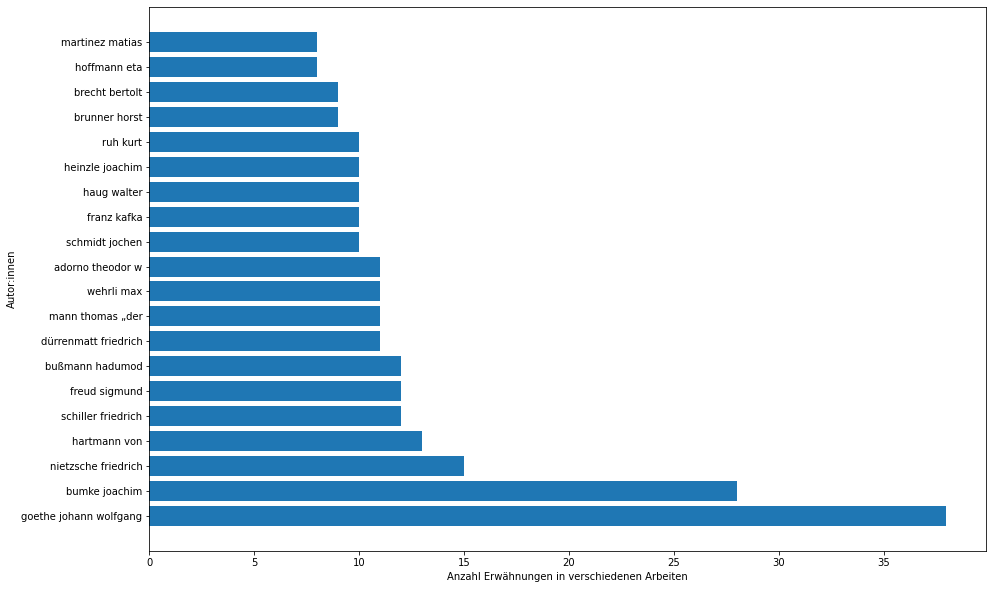

In [175]:
import matplotlib.pyplot as plt
   
name = [k for k in list(final_result.keys())[:20]]
nums = [n for n in list(final_result.values())[:20]]
print(name)
print(nums)

plt.figure(figsize=(15,10))
plt.barh(name,nums)
plt.ylabel('Autor:innen')
plt.xlabel('Anzahl Erwähnungen in verschiedenen Arbeiten')


plt.show()


## Zipf Distribution of author occurrences


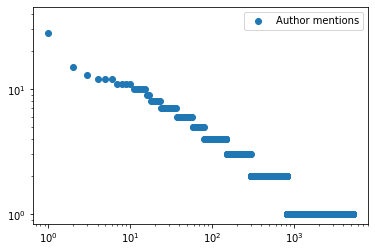

In [173]:
x = len(final_result)
y = sorted(final_result.values(), reverse=True)
plt.scatter(range(x), y,label="Author mentions")
plt.yscale('log')
plt.xscale('log')
plt.legend()

## Create list of canonical authors

In [17]:
### canonical authors (mentions more than 5 times)
important_authors = []
for k,v in final_result.items():
    if v >= 5:
        important_authors.append(k)

In [18]:


percentage= []
### per document only one author
for work in tqdm(works):
    if work.references != "none" and work.link.split("/")[-1] != "283936":
        authors = []
        dics = {}
        ## if author longer than 6 skip name!!
       
        auts = [x.lower() for x in work.ref_authors["autoren"]]
       
        auts = [x.translate(str.maketrans('', '', string.punctuation)) for x in auts]
        
        for aut in auts:
            if len(aut.split(" ")) >= 5 or aut == "" or len(aut.split(" ")) == 1:
                continue
            authors.append(aut)
            
        for index, a in enumerate(authors):
            for na in final_result.keys():
                if is_author(a,na):
                    authors[index] = na
                    break

        sum_authors = len(authors)
        control_num = 0
        
      
        for a in authors:
          
            for n in important_authors:
                if is_author(a,n):
                    control_num+=1
                    break
        
        if sum_authors != 0 :
            percentage.append(control_num/sum_authors)
      

        


  0%|          | 0/1028 [00:00<?, ?it/s]

In [23]:
print("Relativer Anteil kanonischer Autoren: " + str(round(sum(percentage)/len(percentage), 4) *100) + "%")

Relativer Anteil kanonischer Autoren: 13.139999999999999%


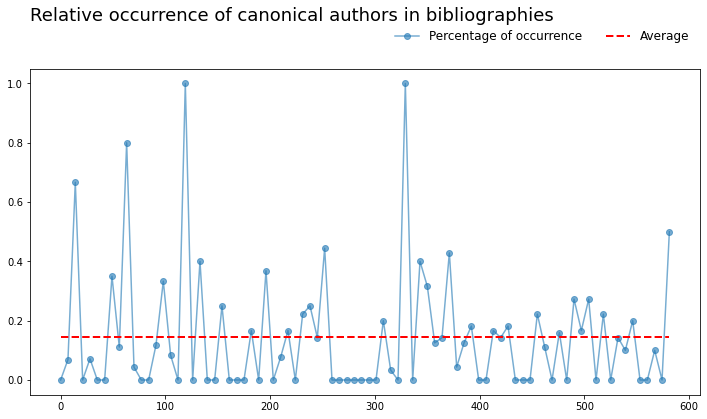

In [156]:
n=7
x = list(range(0, len(percentage),n))
y = percentage[::n]

fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(x,y, alpha=0.6, marker = "o")
plt.plot(x, [sum(y)/len(y)]*len(y), 
         color='red', linewidth=2, linestyle='--')
plt.legend(['Percentage of occurrence', 'Average'], 
           fontsize=12, ncol=2, frameon=False,
           bbox_to_anchor=(0., 1.05, 1., .102))
# plot title
plt.title('Relative occurrence of canonical authors in bibliographies\n\n', 
          loc='left', fontsize=18)
plt.show()
